In [1]:
import torch
from torch import nn, onnx
from torch.nn import functional as F
from torch.optim import Adam
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
def normalize(table: pd.Series) -> torch.Tensor:
    table = table.apply(lambda x: int(x.replace("#", "").replace("\ufeff", "")))
    table = torch.from_numpy(table.to_numpy())

    # От куда я взял эти числа смотри в analis.ipynb
    table[table < -1192] = -1192
    table[table >  1217] =  1217
    table = table - 10.31
    table = table / 1206.7

    return table

In [3]:
_piece = {
    "r": 0, "q": 3,
    "n": 1, "k": 4,
    "b": 2, "p": 5,
}

def hot_coding(fen: str) -> torch.Tensor:
    hot = torch.zeros(385, dtype=torch.int8)
    hidx = 0

    for idx in range(len(fen)):
        if fen[idx] == " ":
            tour = 1 if fen[idx + 1] == "b" else -1
            hot[384] = tour
            break
        elif fen[idx] == "/":
            hidx -= 6;
            continue
        elif fen[idx].lower() not in _piece:
            hidx += int(fen[idx]) * 6 - 6;
            continue

        P = 1 if fen[idx].islower() else -1
        hot[hidx + _piece[fen[idx].lower()]] = P;
        hidx += 6

    return hot

def parse_fen(table: pd.Series) -> torch.Tensor:
    x = []

    for fen in tqdm(table, "Parse FEN"):
        x.append(hot_coding(fen))

    return torch.stack(x)

In [4]:
def read_data(path: str,
              batch: int = 64,
              device: str = "cpu") -> "generator":
    table = pd.read_csv(path)
    fen = parse_fen(table.FEN).to(device).float()  # Очень долго
    eva = normalize(table.Evaluation).to(device)

    rand = torch.randperm(fen.size(0))
    fen = fen[rand]
    eva = eva[rand]
    max_n = round(fen.shape[0] / batch + 0.5)
    n = 0

    while True:
        if (n == max_n):
            rand = torch.randperm(len(fen))
            fen = fen[rand]
            eva = eva[rand]
            n = 0
        else:
            n += 1

        x = fen[batch * n:batch * (n + 1)]
        y = eva[batch * n:batch * (n + 1)]
        yield (x, y)

In [41]:
class ComplexReLU(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.complex(F.relu(x.real), F.relu(x.imag))
        return x

class ComplexCos(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = x.real ** 2 + x.imag ** 2 + 1e-3
        out = x.real / torch.sqrt(out)
        return out

class PlanktonAI(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(385, 5, bias=False, dtype=torch.cfloat), ComplexReLU(),
            nn.Linear( 5,  1, bias=False, dtype=torch.cfloat), ComplexCos(),
        )

    def forward(self, inp: torch.Tensor) -> torch.Tensor:
        inp = torch.complex(inp, torch.zeros_like(inp))
        out = self.fc(inp)
        return out.squeeze(-1)

In [29]:
num_param = lambda m: sum(p.numel() for p in m.parameters())

def train(model: PlanktonAI,
          optimizer: Adam,
          data: "generator",
          loops: int = 64) -> list[float]:
    model.train()
    history = []

    for _ in tqdm(range(loops), "Train model"):
        x, y = next(data)
        out = model(x)
        loss = F.mse_loss(out, y)

        loss.backward()
        optimizer.step()
        model.zero_grad()

        history.append(loss.item())

    plt.title("L2 loss function")
    plt.plot(history)
    return history

In [44]:
bot = PlanktonAI().to("cuda")
optim = Adam(
    bot.parameters(),
    lr=1e-4,
)
data = read_data(
    path="/content/drive/MyDrive/data/chessEval/random_evals.csv",
    batch=70,
    device="cuda",
)
next(data)

print(f"Number parameters in Model: {num_param(bot)}")
print(bot)

Number parameters in Model: 1930
PlanktonAI(
  (fc): Sequential(
    (0): Linear(in_features=385, out_features=5, bias=False)
    (1): ComplexReLU()
    (2): Linear(in_features=5, out_features=1, bias=False)
    (3): ComplexCos()
  )
)


Train model: 100%|██████████| 131072/131072 [04:30<00:00, 483.73it/s]


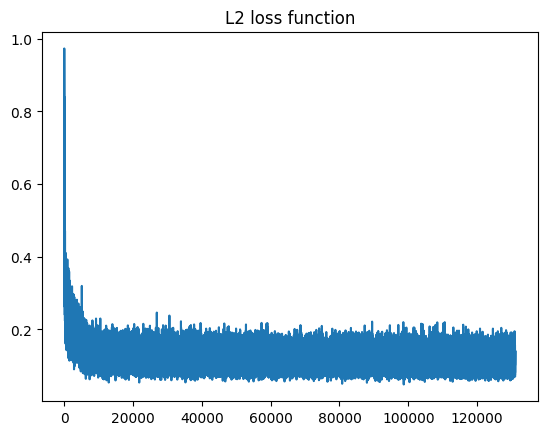

In [45]:
hist = train(
    model = bot,
    optimizer = optim,
    data = data,
    loops = 2**17,
)

In [52]:
# Сохранение модели
bot.eval().cpu()
trace = torch.jit.trace(bot.forward, torch.randn(1, 385))
torch.jit.save(trace, "PlanktonAI.pt")

In [ ]:
# Сохранение модели в формате onnx
bot.eval().cpu()
input = torch.rand(1, 385)

onnx.export(
    model = bot,
    args = input,
    f = "PlanktonBot.onnx",
    export_params = True,
    verbose = True,
    input_names = ["Input"],
    output_names = ["Position assessment"],
    opset_version = 11,
)